In [1]:
#necessary module
import os ; import sys
sys.path.append(os.getcwd()+"/Equantum")
#path to data
datapath="/scratch/zhaoyuha/Datas/EQuantum_data/topgate/"
setuppath="/scratch/zhaoyuha/Datas/EQuantum_data/topgate/setup/"
from sites import Site
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from fsc import FSC
import scipy.linalg as sl
import scipy.constants as sc
import importlib
import poissonsolver as psolver
import kwant
import scipy.io as sio
%matplotlib widget

from EQsystem import System

In [2]:
import fsc
importlib.reload(fsc)
from fsc import FSC

import EQsystem
importlib.reload(EQsystem)
from EQsystem import System
#test module


from scipy.interpolate import interp1d
from scipy.optimize import brentq

import poissonsolver
importlib.reload(poissonsolver)

<module 'poissonsolver' from '/scratch/zhaoyuha/EQuantum/EQuantum/Equantum/poissonsolver.py'>

In [3]:
import qbuilder
importlib.reload(qbuilder)
import poissonsolver
importlib.reload(poissonsolver)
import poissonsolver as psolver

In [4]:
import solvers
importlib.reload(solvers)
from solvers import local_solver

## Define system

In [3]:
def density_function(z):
        spacing0 = 0.005 # spacing at r=0
        k = 0.8  # spacing increases by 0.05 per unit distance
        return spacing0 + k * z

In [6]:
def density_function(z):
        spacing0 = 0.032 # spacing at r=0
        k = 0.2  # spacing increases by 0.05 per unit distance
        if abs(z)<3*spacing0:
            return spacing0   #define same lattice for the layers above/beneath quantum system, avoid oscillation due to the lattice mismatch
        else:
            return spacing0 + k * z

In [4]:
geoparams={"lattice_type": "square",   # or honeycomb_lattice, etc.
"box_size": ((-0.5, 0.5), (-0.5, 0.5), (-0.08, 0.08)),
"sampling_density_function": density_function,
"quantum_center": (0,0,0)     # optional, defaults to (0,0,0)
              }

In [7]:
geoparams={"lattice_type": "honeycomb",   # or honeycomb_lattice, etc.
"box_size": ((-1, 1), (-1, 1), (-0.08, 0.08)),
"sampling_density_function": density_function,
"quantum_center": (0,0,0)     # optional, defaults to (0,0,0)
              }

## Initialize System

In [22]:
syst=System(geoparams,assign_mat=False)
syst.export_sites(filename=setuppath+"sites.json")

Generated 202278 points in 3D.
Voronoi cells have been created.
0 sites have been removed from the system.
EQsystem is successfully initialized.


In [161]:
config_file=setuppath+"001_1_hc_step.json"
syst=System(geoparams,config_file=config_file,ifqsystem=True,quantum_builder="default")

Generated 85430 points in 3D.
Voronoi cells have been created.
20 sites have been removed from the system.
Quantum system is generated using default.
EQsystem is successfully initialized.


In [8]:
syst=System(geoparams,ifqsystem=True,quantum_builder="default")

Generated 18180 points in 3D.
Voronoi cells have been created.
326 sites have been removed from the system.
Quantum system is generated using default.
EQsystem is successfully initialized.


In [9]:
qparams={'Ufunc': lambda x:0,'phi':0.04}
fsc=FSC(syst,ifinitial=False,params=qparams)

The quantum problem has been initialized.


In [10]:
fsc.update_BC(syst,'gate','potential',0.5)
fsc.update_BC(syst,'backgate','potential',0.3,ifinitial=True)

The poisson problem has been initialized.


## Check the Spectrum

In [12]:
ltest=qbuilder.update_ildos(fsc,syst,delta=fsc.t/20,w=np.linspace(-fsc.bandwidth,fsc.bandwidth,2000),TFapprox=False,ifpara=True,Ncore=20)

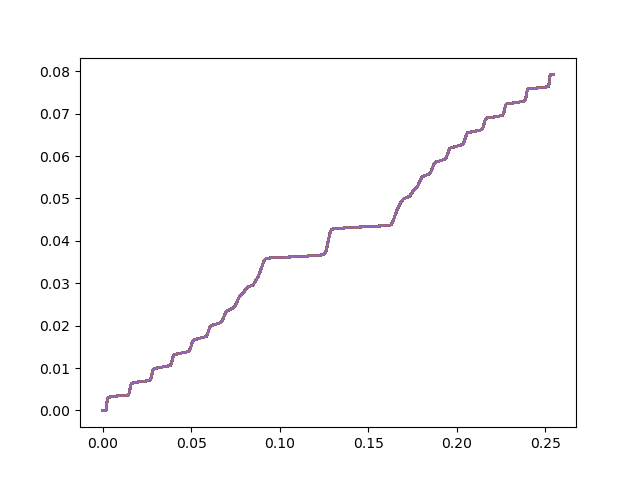

In [25]:
plt.figure()
#plt.plot(ltest[1][0],ltest[1][1])
for ii in range(0,len(fsc.Qsites),20):
    plt.plot(ltest[ii][0],[np.sum(ltest[ii][1][:idx]) for idx in range(len(ltest[ii][0]))])
plt.show()

In [10]:
Atest=np.array([12,4,5,2,1])
Btest=Atest[np.array([2,3])]

In [11]:
Btest[1]=200

In [13]:
Btest

array([  5, 200])

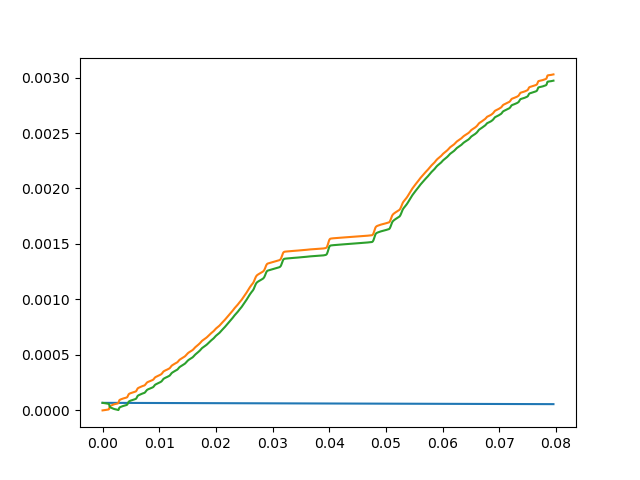

In [11]:
sidx=100
ni=fsc.ni[fsc.Qsites][sidx]
Ci=fsc.Ci[sidx]
ildos=fsc.ildos[sidx]
Ui=fsc.Ui[fsc.Qprime][sidx]

x_dis=ildos[0]-Ui
y_dis=ildos[1]
ildos_dis=[np.sum(y_dis[:idx]) for idx in range(len(x_dis))]
ildos_dis=ildos_dis-0*fsc.max_fill/2
ildos_iterp=interp1d(x_dis,ildos_dis,kind='linear',fill_value='exptrapolate')
def dn_for_Ci(dU):
    return dU*Ci+ni
def diff(dU):
    return np.abs(dn_for_Ci(dU)-ildos_iterp(dU))

plt.figure()
plt.plot(x_dis,[dn_for_Ci(dU) for dU in x_dis])
plt.plot(x_dis,[ildos_iterp(dU) for dU in x_dis])
plt.plot(x_dis,[diff(dU) for dU in x_dis])
#plt.ylim((-0.05,0.05))
#plt.xlim((-0.03,0.03))
#plt.plot(x_dis,ildos_dis)
#plt.plot(fsc.ildos[0][0],fsc.ildos[0][1])
plt.show()

In [20]:
Htest=fsc.qsystem.H.toarray()
pot=np.diagonal(Htest)

In [21]:
ev=np.sort(sl.eigvals(Htest))

In [26]:
ildos=qbuilder.update_ildos(fsc,syst,delta=fsc.t/20,npol_scale=6)

/scratch/zhaoyuha/miniconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


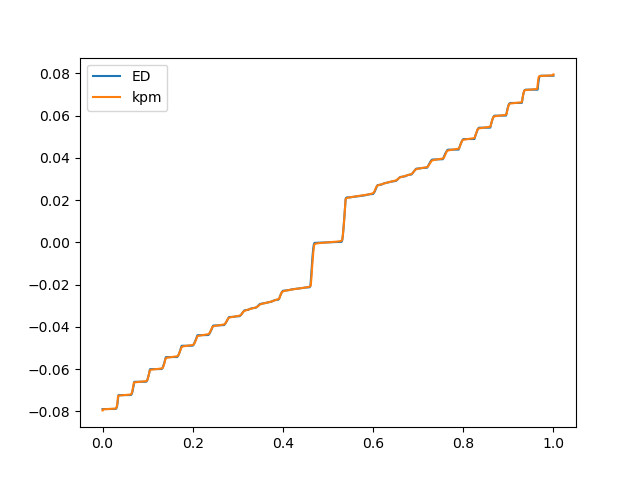

In [ ]:
nden=np.array([np.sum(ildos[0][1][:idx])for idx,ee in enumerate(ildos[0][0])])
plt.figure()
plt.plot(np.linspace(0,1,len(ev)),ev,label='ED')
plt.plot(nden/nden[-1],ildos[0][0]-fsc.bandwidth,label='kpm')
plt.legend()
plt.xax
plt.show()

## Plot System

In [9]:
for site in syst.sites.values():
    site.material='vacuum'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


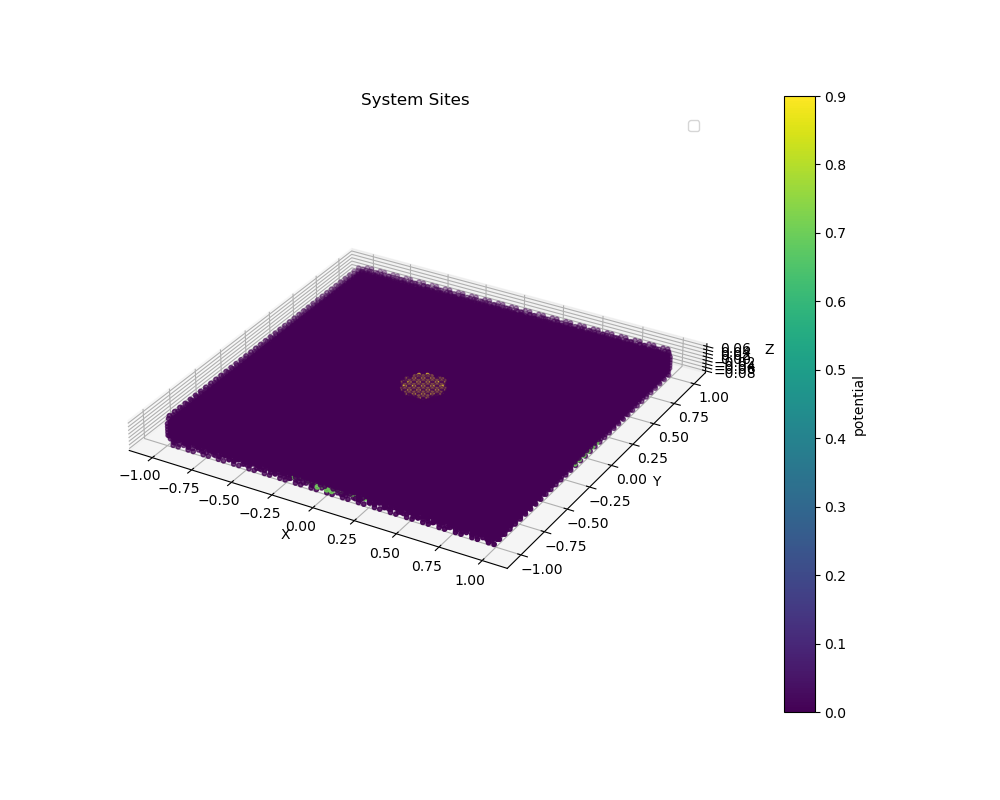

In [8]:
syst.plot_geometry(prop='potential')

In [18]:
gateidx=np.zeros(fsc.num_sites)
for qidx, site in enumerate(fsc.sites.values()): #for all sites in the quantum system
    if site.material=='gate' or site.material == 'Qsystem':
        gateidx[qidx]=fsc.ni[qidx]
gateidx[gateidx==0]='nan'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


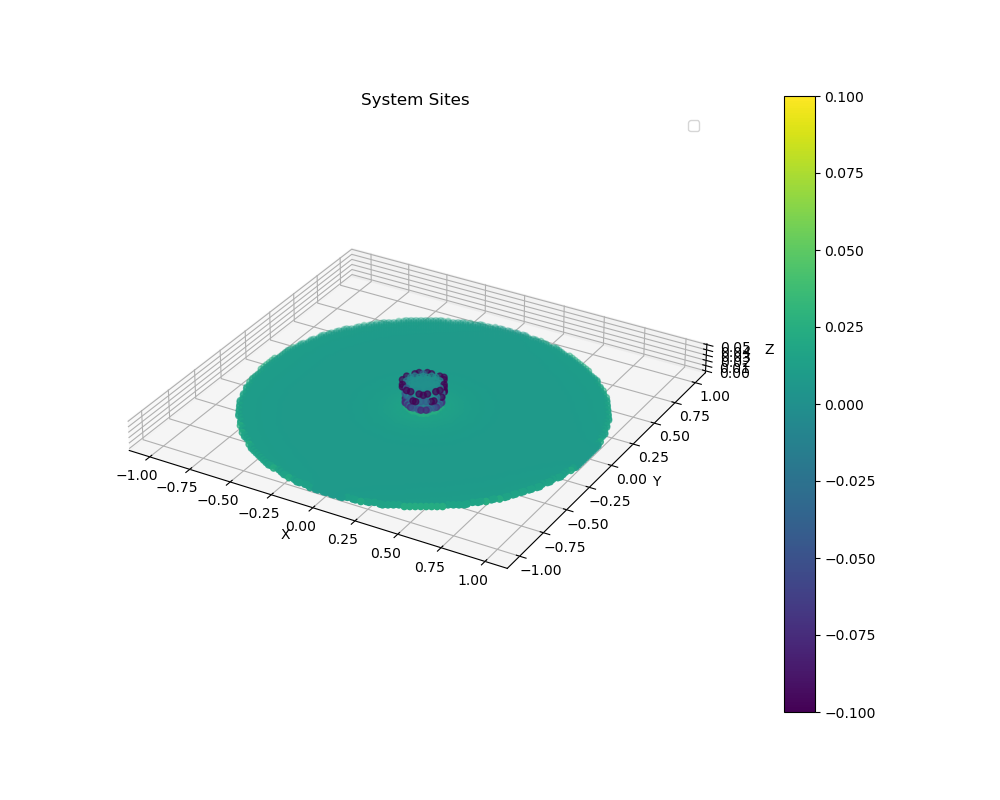

In [19]:
indicate=np.zeros(len(fsc.sites))
indicate[fsc.D_indices]=1
fsc.plot_full(gateidx)

In [94]:
num_neighbor=np.zeros(fsc.num_sites)
for qidx, idx in enumerate(fsc.Qsites): #for all sites in the quantum system
    for neighbor in fsc.sites[idx].neighbors:
        if fsc.sites[neighbor].material=='gate':  # if the neighboring sites also belongs to the Qsystem
            num_neighbor[idx]+=1


In [196]:
indicate=np.zeros(len(fsc.Qsites))
for idx in cut_idx:
    indicate[idx]=fsc.ni[fsc.Qprime][idx]

IndexError: index 7373 is out of bounds for axis 0 with size 7321

In [22]:
for neighbor in fsc.sites[fsc.Qsites[2370]].neighbors:
    print(fsc.sites[neighbor].material)

Qsystem
dielectric
dielectric
Qsystem
Qsystem


In [45]:
indicate=np.zeros(fsc.num_sites)
for idx, qidx in enumerate(fsc.Qprime):
    indicate[qidx]=fsc.Ci[idx]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


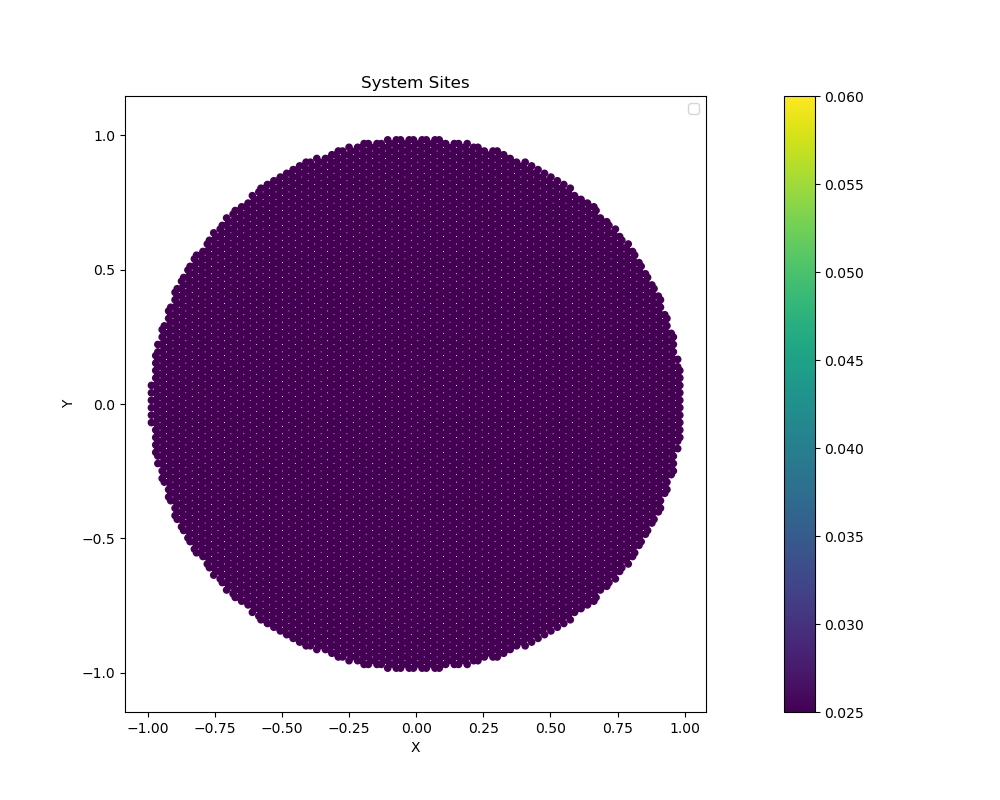

In [30]:
#indicate=np.zeros(fsc.num_sites)
#indicate[fsc.Qprime[1929]]=1
plotdata=fsc.Ui[fsc.Qsites]
#plotdata=dUdn[1]
#plotdata=pot
fsc.plot_qsystem(plotdata,vmin=0.025,vmax=0.06)

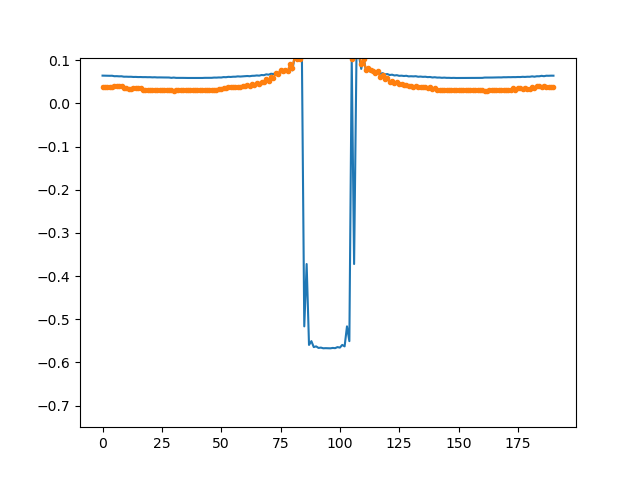

In [24]:
cut_idx=[idx for idx in range(len(fsc.Qsites)) if np.abs(fsc.sites[fsc.Qsites[idx]].coordinates[0])<0.005 and fsc.sites[fsc.Qsites[idx]].material=='Qsystem']
plt.figure()
plt.plot(fsc.Ui[fsc.Qsites][cut_idx])
plt.plot(10*fsc.ni[fsc.Qsites][cut_idx]-0.1,'.-')
#plt.plot(fsc.Ci[cut_idx])
plt.ylim([-0.75,fsc.bandwidth])
plt.show()

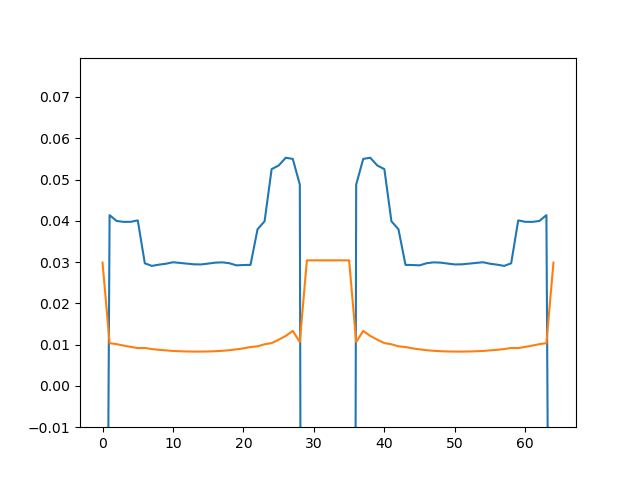

In [127]:
cut_idx=[idx for idx in range(len(fsc.Qsites)) if np.abs(fsc.sites[fsc.Qsites[idx]].coordinates[0])<0.005 and fsc.sites[fsc.Qsites[idx]].material=='Qsystem']
plt.figure()
plt.plot(fsc.Ui[fsc.Qsites][cut_idx])
plt.plot(fsc.ni[fsc.Qsites][cut_idx])
#plt.plot(fsc.Ci[cut_idx])
plt.ylim([-0.01,fsc.bandwidth])
plt.show()

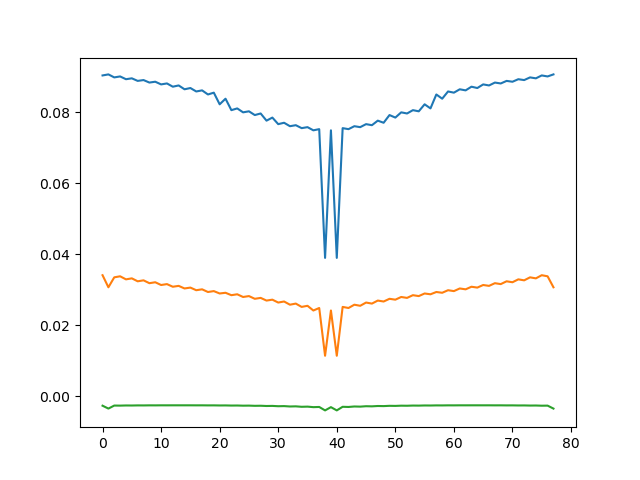

In [17]:
cut_idx=[idx for idx in range(len(fsc.Qprime)) if np.abs(fsc.sites[fsc.Qprime[idx]].coordinates[0])<0.005 and fsc.sites[fsc.Qprime[idx]].material=='Qsystem']
plt.figure()
plt.plot(fsc.Ui[fsc.Qprime][cut_idx])
plt.plot(fsc.ni[fsc.Qprime][cut_idx])
plt.plot(0.1*fsc.Ci[cut_idx])
plt.show()

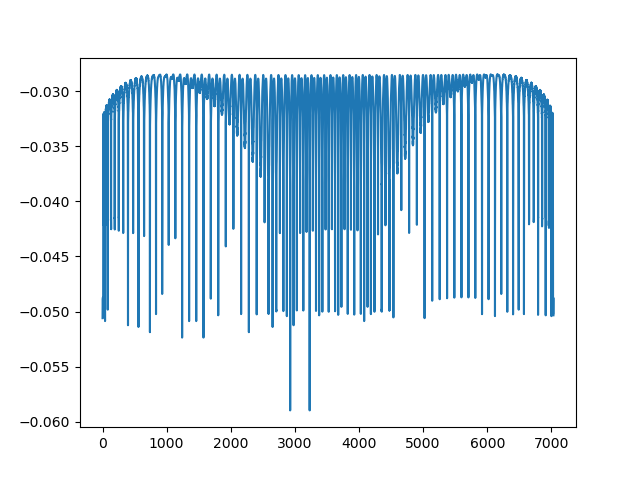

In [72]:
plt.figure()
#plt.plot(fsc.Ui[fsc.Qprime][cut_idx])
#plt.plot(fsc.ni[fsc.Qprime][cut_idx])
plt.plot(fsc.Ci)
plt.show()

## Solve FSC

In [ ]:
fsc.Ncore=20
fsc.convergence_tol=1e-6
fsc.solve(syst,save=datapath+"test")

In [12]:
fsc.Ncore=20

In [13]:
fsc.update_Qprime()

In [14]:
fsc.local_solver()

0.007166020396795908 -1.0727759359496624e-05


In [11]:
fsc.log

{'ni_error': [1, 1.6421525834608238e-05, 0.0],
 'Qprime_len': [9268, 9161],
 'ildos_error': [1]}

In [15]:
fsc.update_Poisson()

In [16]:
fsc.update_Quantum(syst,approx="symmetry",Ncore=20,num_sample=20)

In [15]:
fsc.ildos.shape

(9268, 2, 4634)

In [47]:
qbuilder.update_U(fsc,syst)

In [16]:
ildostest=qbuilder.update_ildos(fsc,syst,delta=fsc.t/20,approx="symmetry",Ncore=20,num_sample=20)

In [18]:
Erange=np.linspace(-fsc.bandwidth,fsc.bandwidth,int(len(fsc.Qsites)/2))

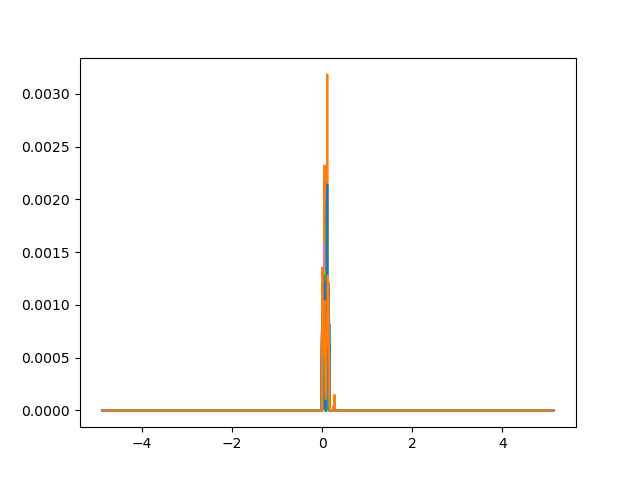

In [20]:
plt.figure()
for ii in range(1,9161,90):
    plt.plot(ildostest[ii,0,:],ildostest[ii,1,:])
plt.show()

In [44]:
fsc.ni[fsc.Qsites]=qbuilder.get_n_from_ildos(fsc,fsc.ildos)

AttributeError: module 'fsc' has no attribute 'ildos'

In [215]:
fsc.ildos[0][0]

array([0.00000000e+00, 1.04091616e-04, 2.08183231e-04, ...,
       2.54295817e-01, 2.54399908e-01, 2.54504000e-01])

In [94]:
num_sample=20
center = np.array([0.,0.,0.])
site_radii=[]
# Compute radial distances for each site (x-y plane)
for site in syst.qsystem.Qsites:
    coord = np.array(site.coordinates)
    # Compute radial distance in x-y plane relative to center
    r = np.linalg.norm(coord[:2] - center[:2])
    site_radii.append(r)

# Gather all radial distances.
site_radii = np.array(site_radii)

# Define radial bins (n+1 bin edges for n bins)
r_min, r_max = site_radii.min(), site_radii.max()
bins = np.linspace(r_min, r_max, num_sample + 1)

In [120]:
bins[20]

0.4499238444104585

In [126]:
bins[0]

0.0024996755353666367

In [129]:
np.argmax(site_radii)

12

In [138]:
[np.where((site_radii>=bins[num_sample]))[0]]

[array([  12, 3041])]

In [146]:
np.where((site_radii>=bins[num_sample]))[0]

array([  12, 3041])

In [163]:
site_in_b[-1]

array([  12, 3041])

In [174]:
site_in_b=[np.where((site_radii >= bins[b]) & (site_radii < bins[b+1]))[0] for b in range(num_sample)]
site_in_b[-1]=np.append(site_in_b[-1],np.where((site_radii>=bins[num_sample]))[0])
def calculate_ldos_in_bin(bidx,**kwargs):
    indices=site_in_b[bidx]
    rep_site = indices[int(len(indices)/2)]
    ldos_value = syst.qsystem.get_dos(i=rep_site,**kwargs)
    return ldos_value

In [173]:
np.where((site_radii>=bins[num_sample]))[0]

array([  12, 3041])

In [99]:
from joblib import Parallel, delayed

In [103]:
bin_ldos=Parallel(n_jobs=20)(delayed(calculate_ldos_in_bin)(bidx,delta=fsc.t/20,w=np.linspace(-fsc.bandwidth,fsc.bandwidth,int(len(fsc.Qsites)/2))) for bidx in range(num_sample))

In [179]:
dataall=[]

In [180]:
for bidx in range(num_sample):
    dataall.append(np.array([bin_ldos[bidx] for _ in range(len(site_in_b[bidx]))]))

In [176]:
np.sum([len(site_in_b[bidx]) for bidx in range(20)])

4892

In [194]:
sortidx=np.argsort(np.concatenate([(site_in_b[bidx]) for bidx in range(20)]))

In [192]:
set(range(4892))-set(np.concatenate([(site_in_b[bidx]) for bidx in range(20)]))

set()

In [206]:
dataalll=np.array(np.concatenate(dataall)[sortidx])

In [208]:
dataalll[:,1,:]*=fsc.max_fill
dataalll[:,0,:]+=fsc.bandwidth

In [209]:
fsc.ildos=dataalll

In [27]:
import quantum_solvers
importlib.reload(quantum_solvers)
from quantum_solvers import default_solver

In [16]:
center = np.array([0.,0.,0.])
site_radii=[]
for site in fsc.qsystem.Qsites:
    coord = np.array(site.coordinates)
    # Compute radial distance in x-y plane relative to center
    r = np.linalg.norm(coord[:2] - center[:2])
    site_radii.append(r)

In [17]:
site_radii = np.array(site_radii)      
# Define radial bins (n+1 bin edges for n bins)
r_min, r_max = site_radii.min(), site_radii.max()
bins = np.linspace(r_min, r_max, 10 + 1)

In [18]:
site_in_b=np.array([np.where((site_radii >= bins[b]) & (site_radii < bins[b+1]))[0] for b in range(10)],dtype=object)

In [29]:
np.where(np.concatenate(site_in_b)==6)

(array([], dtype=int64),)

In [26]:
np.argmax(site_radii)

6

In [25]:
bins

array([0.00249968, 0.05035184, 0.098204  , 0.14605616, 0.19390832,
       0.24176048, 0.28961264, 0.3374648 , 0.38531696, 0.43316912,
       0.48102128])

In [24]:
len(site_radii)

4904

In [37]:
def calculate_ldos_in_bin(bidx,**kwargs):
    indices=site_in_b[bidx]
    rep_site = indices[int(len(indices)/2)]
    ldos_value = fsc.qsystem.get_dos(i=rep_site,**kwargs)
    return ldos_value

In [21]:
from joblib import Parallel, delayed

In [35]:
indices=site_in_b[2]
rep_site=indices[int(len(indices)/2)]


In [ ]:
fsc.qsystem.q

2516

In [39]:
bin_ldos=Parallel(n_jobs=5)(delayed(calculate_ldos_in_bin)(bidx,delta=syst.t/20,w=np.linspace(-fsc.bandwidth,fsc.bandwidth,int(len(syst.Qsites)/2))) for bidx in range(10))

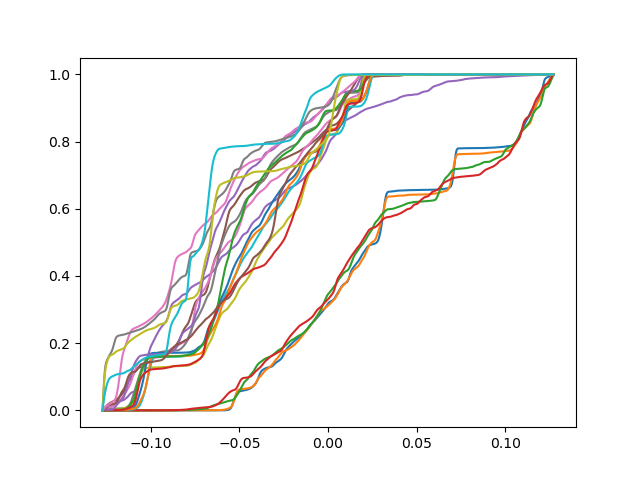

In [225]:
plt.figure()
for bb in range(len(bin_ldos)):
    #plt.plot(bin_ldos[bb][0],bin_ldos[bb][1])
    plt.plot(bin_ldos[bb][0],[np.sum(bin_ldos[bb][1][:idx]) for idx in range(len(bin_ldos[bb][0]))])
plt.show()

In [9]:
ldostest=fsc.qsystem.sample_ldos(Ncore=10)

In [14]:
cut_idx=[qidx for qidx,idx in enumerate(fsc.Qprime) if np.abs(syst.sites[idx].coordinates[0])<0.008 and syst.sites[idx].material=='Qsystem']
coords=[fsc.sites[fsc.Qprime[idx]].coordinates[1] for idx in cut_idx]

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Color sites based on a continuous property, e.g., "charge".
ndens=[np.sum(fsc.ildos[idx,1][:ide]) for ide in range(len(fsc.ildos[idx,0]))]


coords = np.array(coords)
prop_values = np.array(prop_values)

# Create a normalization and a ScalarMappable for the colormap.
#norm = mcolors.Normalize(vmin=np.min(prop_values), vmax=np.max(prop_values))
cmap = cm.viridis
sc = ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2],
                c=prop_values, cmap=cmap, s=20,vmin=np.min(prop_values), vmax=np.max(prop_values),**kwarg)
# Add a colorbar to indicate the property values.
cbar = fig.colorbar(sc, ax=ax, pad=0.1)
#cbar.set_label(prop_values)
box_size=self.geometry_params['box_size']
ax.set_box_aspect((box_size[0][1]-box_size[0][0], box_size[1][1]-box_size[1][0], box_size[2][1]-box_size[2][0]))
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("System Sites")
ax.legend()
plt.show()

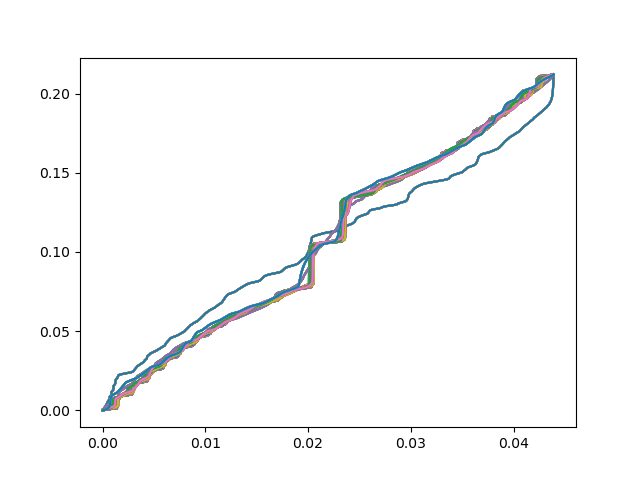

In [15]:
cut_idx=[qidx for qidx,idx in enumerate(fsc.Qsites) if np.abs(syst.sites[idx].coordinates[0])<0.005 and syst.sites[idx].material=='Qsystem']
coords=[fsc.sites[fsc.Qsites[idx]].coordinates for idx in cut_idx]

plt.figure()
for idx in cut_idx:
    nden=np.array([np.sum(fsc.ildos[idx,1][:ide]) for ide in range(len(fsc.ildos[idx,0]))])
    plt.plot(nden,fsc.ildos[idx,0])
plt.show()

In [185]:
fsc.max_fill

0.030419882641943143

In [ ]:
ildoss=[[np.sum(fsc.ildos[idx,1][:ide]) for ide in range(len(fsc.ildos[idx,0]))] for idx in cut_idx]

In [16]:
positions =np.array([fsc.sites[fsc.Qsites[idx]].coordinates[1] for idx in cut_idx])    # example: 100 positions
energies = fsc.ildos[0,0,:]   
ildoss = np.array([[np.sum(fsc.ildos[idx,1][:ide]) for ide in range(len(fsc.ildos[idx,0])) ] for idx in cut_idx])
ildoss = np.transpose(ildoss) # dummy function
onsite_U=fsc.Ui[fsc.Qsites][cut_idx]

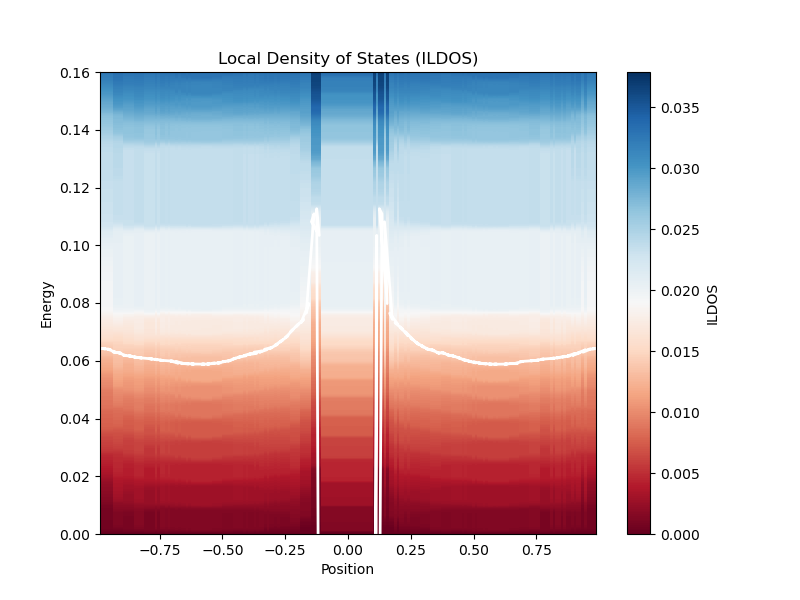

In [18]:
plt.figure(figsize=(8, 6))
# extent sets the x- and y- axes: [xmin, xmax, ymin, ymax]
plt.imshow(ildoss, extent=[positions.min(), positions.max(), energies.min(), energies.max()],
           aspect='auto', origin='lower', cmap='RdBu',vmin=0,vmax=fsc.max_fill-0.006,interpolation='none')

plt.plot(positions, onsite_U,linewidth=2,c='w')
plt.ylim(0,0.16)
plt.colorbar(label='ILDOS')
plt.xlabel("Position")
plt.ylabel("Energy")
plt.title("Local Density of States (ILDOS)")
plt.show()

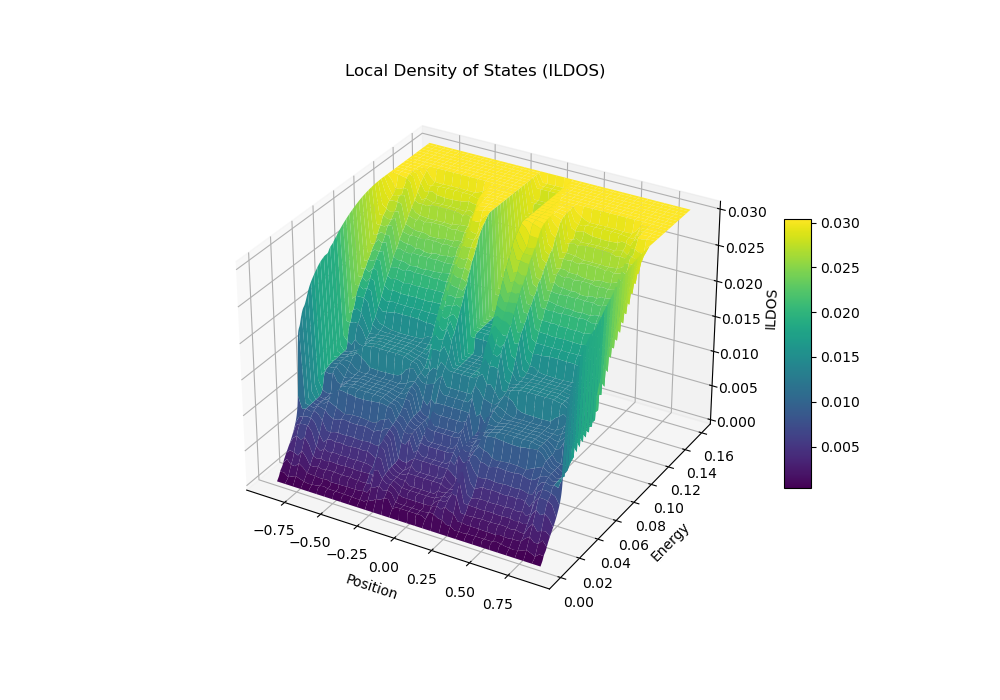

In [173]:



# Create a meshgrid from positions and energies
X, Y = np.meshgrid(positions, energies)

# Set up the figure and 3D axis
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface; adjust the colormap as desired
surf = ax.plot_surface(X, Y, ildoss, cmap='viridis', edgecolor='none')

# Label axes
ax.set_xlabel("Position")
ax.set_ylabel("Energy")
ax.set_zlabel("ILDOS")

# Add a color bar for reference
fig.colorbar(surf, shrink=0.5, aspect=10)

plt.title("Local Density of States (ILDOS)")
plt.show()

In [26]:

data=sio.loadmat("/scratch/zhaoyuha/Datas/EQuantum_data/topgate/test")
Uis=data['Uis']
nis=data['nis']

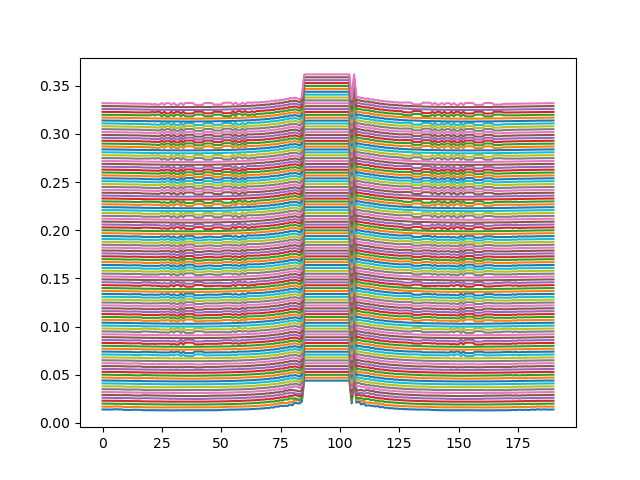

In [28]:
cut_idx=[idx for idx in range(len(syst.sites)) if np.abs(syst.sites[idx].coordinates[0])<0.005 and syst.sites[idx].material=='Qsystem']
plt.figure()
for idxu, Uii in enumerate(nis):
    plt.plot(Uii[cut_idx]+idxu*0.003)
plt.show()